In [2]:
import os
import json
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [9]:
from typing import Dict, List

import string

import regex as re


def normalize_answer(s: str) -> str:
    """Normalization from the SQuAD evaluation script.

    See https://worksheets.codalab.org/rest/bundles/0x6b567e1cf2e041ec80d7098f031c5c9e/contents/blob/
    """

    def remove_articles(text):
        return re.sub(r"\b(a|an|the)\b", " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def best_em(prediction: str, ground_truths: List[str]) -> float:
    normalized_prediction = normalize_answer(prediction)

    for ground_truth in ground_truths:
        normalized_ground_truth = normalize_answer(ground_truth)
        if normalized_ground_truth.lower() == normalized_prediction.lower():
            return 1.0
    return 0.0


def best_subspan_em(prediction: str, ground_truths: List[str]) -> float:
    normalized_prediction = normalize_answer(prediction)

    for ground_truth in ground_truths:
        normalized_ground_truth = normalize_answer(ground_truth)
        if normalized_ground_truth.lower() in normalized_prediction.lower():
            return 1.0
    return 0.0


In [82]:
decore_cb_filepath = "../predictions/nq_closed_book/pred_NQ_DeCoReEntropy_10.json"
decore_ob_filepath = "../predictions/nq_open_book/pred_NQ_DeCoReEntropy_10.json"
baseline_cb_filepath = "../predictions/nq_closed_book/pred_NQ_Baseline.json"
baseline_ob_filepath = "../predictions/nq_open_book/pred_NQ_Baseline.json"
dola_cb_filepath = "../predictions/nq_closed_book/pred_NQ_DoLa_High.json"
dola_ob_filepath = "../predictions/nq_open_book/pred_NQ_DoLa_High.json"

def load_data(filepath):
    data = []
    with open(filepath, "r") as f:
        for line in f:
            data += [json.loads(line)]
    
    questions = []
    answers = []
    predicted_answers = []
    contexts = []
    labels = []
    for i in range(len(data)):
        answers_list = [ans[0] for ans in data[i]["answers"]]

        is_correct = best_subspan_em(data[i]["predicted_answer"], answers_list)
        predicted_answers += [data[i]["predicted_answer"]]
        contexts += [data[i]["contexts"] if "contexts" in data[i] else []]
        questions += [data[i]["question"]]
        answers += [answers_list]
        labels += [is_correct]

    return {
        "contexts": contexts,
        "questions": questions,
        "answers": answers,
        "predicted_answers": predicted_answers,
        "labels": labels
    }
    
decore_cb_data = load_data(decore_cb_filepath)
decore_ob_data = load_data(decore_ob_filepath)
baseline_cb_data = load_data(baseline_cb_filepath)
baseline_ob_data = load_data(baseline_ob_filepath)
dola_cb_data = load_data(dola_cb_filepath)
dola_ob_data = load_data(dola_ob_filepath)

In [77]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(closed_book_predictions, open_book_predictions):
    # Create a confusion matrix with labels for both 0 and 1
    cm = confusion_matrix(closed_book_predictions, open_book_predictions, labels=[0, 1])
    
    # Convert the confusion matrix to a pandas DataFrame
    cm_df = pd.DataFrame(cm, index=['Incorrect', 'Correct'], columns=['Incorrect', 'Correct'])
    
    # Normalize the confusion matrix by dividing by the sum of all values
    cm_percentage = cm_df / cm_df.sum().sum() * 100

    # Calculate the Open book correct AND Closed book incorrect / Closed book Incorrect
    open_correct_closed_incorrect = cm_df.loc['Incorrect', 'Correct'] / cm_df.loc['Incorrect'].sum()

    # Calculate Closed book correct AND Open book incorrect / Closed book Correct
    closed_correct_open_incorrect = cm_df.loc['Correct', 'Incorrect'] / cm_df.loc['Correct'].sum()

    print(cm_df.loc['Incorrect', 'Correct'])
    print(cm_df.loc['Incorrect'].sum())

    print("Open book correct AND Closed book incorrect / Closed book Incorrect: {:.2f}%".format(open_correct_closed_incorrect*100))
    print("Closed book correct AND Open book incorrect / All: {:.2f}%".format(closed_correct_open_incorrect*100))
    
    # Print the percentage DataFrame to verify
    print("Confusion Matrix Percentage DataFrame:")
    print(cm_df)
    print(cm_percentage)
    
    # Plot the confusion matrix using Matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm_df, cmap='rocket')

    for (i, j), val in np.ndenumerate(cm_df.values):
        ax.text(j, i, f'{val}', ha='center', va='center', color='white', fontsize=14)
    
    plt.xlabel('Open Book Predictions')
    plt.ylabel('Closed Book Predictions')
    plt.title('Confusion Matrix (Percentage)')
    plt.colorbar(cax)
    plt.xticks(range(len(cm_df.columns)), cm_df.columns, rotation=45)
    plt.yticks(range(len(cm_df.index)), cm_df.index)
    plt.show()

1314
1837
Open book correct AND Closed book incorrect / Closed book Incorrect: 71.53%
Closed book correct AND Open book incorrect / All: 4.89%
Confusion Matrix Percentage DataFrame:
           Incorrect  Correct
Incorrect        523     1314
Correct           40      778
           Incorrect    Correct
Incorrect  19.698682  49.491525
Correct     1.506591  29.303202


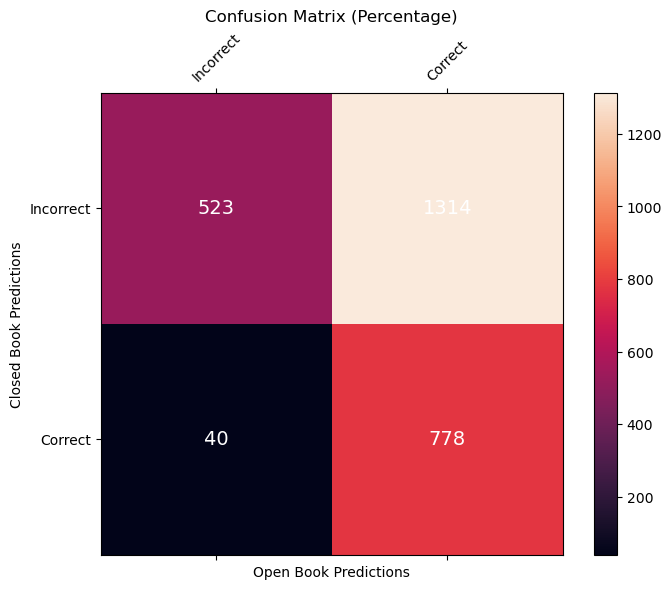

In [78]:
plot_confusion_matrix(decore_cb_data["labels"], decore_ob_data["labels"])

1269
1823
Open book correct AND Closed book incorrect / Closed book Incorrect: 69.61%
Closed book correct AND Open book incorrect / All: 4.93%
Confusion Matrix Percentage DataFrame:
           Incorrect  Correct
Incorrect        554     1269
Correct           41      791
           Incorrect    Correct
Incorrect  20.866290  47.796610
Correct     1.544256  29.792844


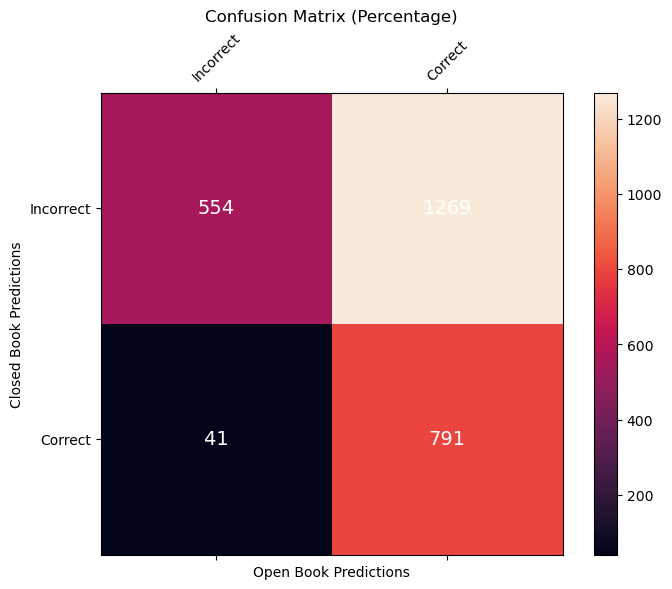

In [79]:
plot_confusion_matrix(baseline_cb_data["labels"], baseline_ob_data["labels"])

1266
1826
Open book correct AND Closed book incorrect / Closed book Incorrect: 69.33%
Closed book correct AND Open book incorrect / All: 4.83%
Confusion Matrix Percentage DataFrame:
           Incorrect  Correct
Incorrect        560     1266
Correct           40      789
           Incorrect    Correct
Incorrect  21.092279  47.683616
Correct     1.506591  29.717514


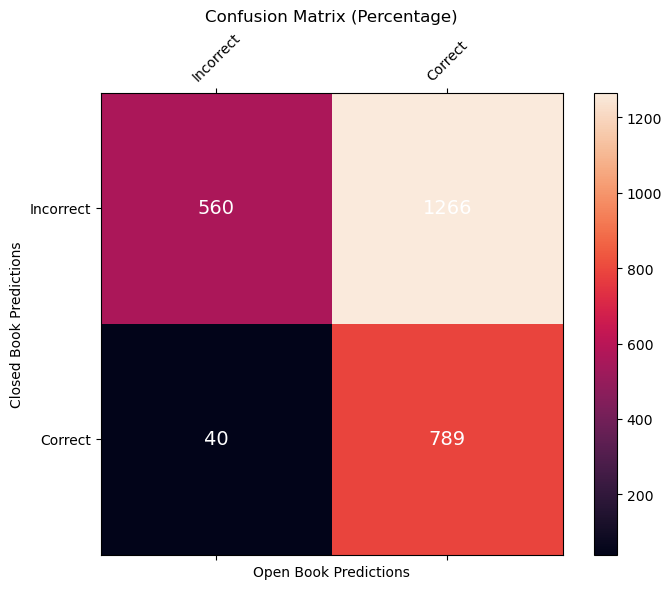

In [80]:
plot_confusion_matrix(dola_cb_data["labels"], dola_ob_data["labels"])

In [100]:
decore_idx = []
decore_cb_incorrect_ob_correct_idx = []

for idx, (cb_label, ob_label) in enumerate(zip(decore_cb_data["labels"], decore_ob_data["labels"])):
    if cb_label and not ob_label:
        print("=====================================")
        print("IDX: ", idx)
        print("Contexts: ", decore_ob_data["contexts"][idx])
        print("Question: ", decore_cb_data["questions"][idx])
        print("Answers: ", decore_cb_data["answers"][idx])
        print("Closed book: ", decore_cb_data["predicted_answers"][idx])
        print("Open book: ", decore_ob_data["predicted_answers"][idx])
        print("=====================================")
        decore_idx += [idx]
    if not cb_label and ob_label:
        decore_cb_incorrect_ob_correct_idx += [idx]

IDX:  5
Contexts:  [['(Title: Reading F.C.) Reading Football Club ownership structure: 75% Owned by Renhe Sports Management Ltd, 100% owned by Xiu Li Dai and Yongge Dai. 25% Owned by Narin Niruttinanon']]
Question:  ['who is the owner of reading football club']
Answers:  ['Xiu Li Dai', 'Dai Xiuli', 'Dai Yongge', 'Yongge Dai']
Closed book:  Dai Yongge
Open book:  Renhe Sports Management Ltd
IDX:  49
Contexts:  [["(Title: 2018 Winter Olympics) The 2018 Winter Olympics, officially known as the XXIII Olympic Winter Games (French: Les XXIIIèmes Jeux olympiques d'hiver; Hangul:\xa0제23회 동계 올림픽; RR:\xa0Je-isipsamhoe Donggye Ollimpik) and commonly known as PyeongChang 2018 ([pʰjʌŋ.tɕʰaŋ]), is a major international multi-sport event scheduled to take place from 9 to 25 February 2018 in Pyeongchang County, South Korea."]]
Question:  ['where are the winter olympics and when do they start']
Answers:  ['Pyeongchang County, South Korea', 'Pyeongchang, South Korea', '9 to 25 February 2018', '9 Februar

In [101]:
baseline_idx = []
baseline_cb_incorrect_ob_incorrect_idx = []

for idx, (cb_label, ob_label) in enumerate(zip(baseline_cb_data["labels"], baseline_ob_data["labels"])):
    if cb_label and not ob_label:
        print("=====================================")
        print("IDX: ", idx)
        print("Contexts: ", baseline_ob_data["contexts"][idx])
        print("Question: ", baseline_cb_data["questions"][idx])
        print("Answers: ", baseline_cb_data["answers"][idx])
        print("Closed book: ", baseline_cb_data["predicted_answers"][idx])
        print("Open book: ", baseline_ob_data["predicted_answers"][idx])
        print("=====================================")
        baseline_idx += [idx]
    if not cb_label and not ob_label:
        baseline_cb_incorrect_ob_incorrect_idx += [idx]

IDX:  49
Contexts:  [["(Title: 2018 Winter Olympics) The 2018 Winter Olympics, officially known as the XXIII Olympic Winter Games (French: Les XXIIIèmes Jeux olympiques d'hiver; Hangul:\xa0제23회 동계 올림픽; RR:\xa0Je-isipsamhoe Donggye Ollimpik) and commonly known as PyeongChang 2018 ([pʰjʌŋ.tɕʰaŋ]), is a major international multi-sport event scheduled to take place from 9 to 25 February 2018 in Pyeongchang County, South Korea."]]
Question:  ['where are the winter olympics and when do they start']
Answers:  ['Pyeongchang County, South Korea', 'Pyeongchang, South Korea', '9 to 25 February 2018', '9 February']
Closed book:  Pyeongchang, South Korea, 9th February
Open book:  Pyeongchang, February 9-25
IDX:  92
Contexts:  [['(Title: Gina Tognoni) Gina Tognoni /toʊnˈjoʊni/ (born November 28, 1973) is an American actress, best known for her work with American daytime soap operas.  Her most notable performances include Kelly Cramer on One Life to Live and Dinah Marler on Guiding Light. She is curr

In [86]:
dola_idx = []

for idx, (cb_label, ob_label) in enumerate(zip(dola_cb_data["labels"], dola_ob_data["labels"])):
    if cb_label and not ob_label:
        print("=====================================")
        print("IDX: ", idx)
        print("Contexts: ", dola_ob_data["contexts"][idx])
        print("Question: ", dola_cb_data["questions"][idx])
        print("Answers: ", dola_cb_data["answers"][idx])
        print("Closed book: ", dola_cb_data["predicted_answers"][idx])
        print("Open book: ", dola_ob_data["predicted_answers"][idx])
        print("=====================================")
        dola_idx += [idx]

IDX:  49
Contexts:  [["(Title: 2018 Winter Olympics) The 2018 Winter Olympics, officially known as the XXIII Olympic Winter Games (French: Les XXIIIèmes Jeux olympiques d'hiver; Hangul:\xa0제23회 동계 올림픽; RR:\xa0Je-isipsamhoe Donggye Ollimpik) and commonly known as PyeongChang 2018 ([pʰjʌŋ.tɕʰaŋ]), is a major international multi-sport event scheduled to take place from 9 to 25 February 2018 in Pyeongchang County, South Korea."]]
Question:  ['where are the winter olympics and when do they start']
Answers:  ['Pyeongchang County, South Korea', 'Pyeongchang, South Korea', '9 to 25 February 2018', '9 February']
Closed book:  Pyeongchang, South Korea, Feb
Open book:  Pyeongchang, February 9
IDX:  92
Contexts:  [['(Title: Gina Tognoni) Gina Tognoni /toʊnˈjoʊni/ (born November 28, 1973) is an American actress, best known for her work with American daytime soap operas.  Her most notable performances include Kelly Cramer on One Life to Live and Dinah Marler on Guiding Light. She is currently starri

In [90]:
print(len(set(decore_idx) - set(baseline_idx)))
for idx in list(set(decore_idx) - set(baseline_idx)):
    print("=====================================")
    print("IDX: ", idx)
    print("Contexts: ", decore_ob_data["contexts"][idx])
    print("Question: ", decore_cb_data["questions"][idx])
    print("Answers: ", decore_cb_data["answers"][idx])
    print("DeCoRe Closed book: ", decore_cb_data["predicted_answers"][idx])
    print("DeCoRe Open book: ", decore_ob_data["predicted_answers"][idx])
    print("Baseline Closed book: ", baseline_cb_data["predicted_answers"][idx])
    print("Baseline Open book: ", baseline_ob_data["predicted_answers"][idx])
    print("=====================================")

6
IDX:  931
Contexts:  [['(Title: URL) Most web browsers display the URL of a web page above the page in an address bar. A typical URL could have the form http://www.example.com/index.html, which indicates a protocol (http), a hostname (www.example.com), and a file name (index.html).']]
Question:  ['what is the general structure of an url']
Answers:  ['a protocol', 'a hostname', 'a file name']
DeCoRe Closed book:  Protocol://domain/path
DeCoRe Open book:  http://www.example.com/index.html
Baseline Closed book:  Protocol://domain/path
Baseline Open book:  http://hostname/filename
IDX:  5
Contexts:  [['(Title: Reading F.C.) Reading Football Club ownership structure: 75% Owned by Renhe Sports Management Ltd, 100% owned by Xiu Li Dai and Yongge Dai. 25% Owned by Narin Niruttinanon']]
Question:  ['who is the owner of reading football club']
Answers:  ['Xiu Li Dai', 'Dai Xiuli', 'Dai Yongge', 'Yongge Dai']
DeCoRe Closed book:  Dai Yongge
DeCoRe Open book:  Renhe Sports Management Ltd
Baselin

In [97]:
len(set(baseline_idx))

41

In [98]:
len(set(decore_idx))

40

In [94]:
print(len(set(baseline_idx) - set(decore_idx)))
for idx in list(set(baseline_idx) - set(decore_idx)):
    print("=====================================")
    print("IDX: ", idx)
    print("Contexts: ", decore_ob_data["contexts"][idx])
    print("Question: ", decore_cb_data["questions"][idx])
    print("Answers: ", decore_cb_data["answers"][idx])
    print("DeCoRe Closed book: ", decore_cb_data["predicted_answers"][idx])
    print("DeCoRe Open book: ", decore_ob_data["predicted_answers"][idx])
    print("Baseline Closed book: ", baseline_cb_data["predicted_answers"][idx])
    print("Baseline Open book: ", baseline_ob_data["predicted_answers"][idx])
    print("=====================================")

7
IDX:  2536
Contexts:  [['(Title: Canadian Charter of Rights and Freedoms) The task of interpreting and enforcing the Charter falls to the courts, with the Supreme Court of Canada being the ultimate authority on the matter.']]
Question:  ['who enforces the charter of rights and freedoms']
Answers:  ['Supreme Court of Canada', 'the courts', 'courts', 'The courts']
DeCoRe Closed book:  Canadian Charter
DeCoRe Open book:  Supreme Court Canada
Baseline Closed book:  Courts
Baseline Open book:  Supreme Court Canada
IDX:  778
Contexts:  [['(Title: The Walking Dead (season 8)) The eighth season of The Walking Dead, an American post-apocalyptic horror television series on AMC, premiered on October 22, 2017, and concluded on April 15, 2018, consisting of 16 episodes.  Developed for television by Frank Darabont, the series is based on the eponymous series of comic books by Robert Kirkman, Tony Moore, and Charlie Adlard. The executive producers are Kirkman, David Alpert, Scott M. Gimple, Greg Ni

In [91]:
print(len(set(dola_idx) - set(baseline_idx)))
for idx in list(set(dola_idx) - set(baseline_idx)):
    print("=====================================")
    print("IDX: ", idx)
    print("Contexts: ", dola_ob_data["contexts"][idx])
    print("Question: ", dola_cb_data["questions"][idx])
    print("Answers: ", dola_cb_data["answers"][idx])
    print("DeCoRe Closed book: ", dola_cb_data["predicted_answers"][idx])
    print("DeCoRe Open book: ", dola_ob_data["predicted_answers"][idx])
    print("Baseline Closed book: ", baseline_cb_data["predicted_answers"][idx])
    print("Baseline Open book: ", baseline_ob_data["predicted_answers"][idx])
    print("=====================================")

1
IDX:  1560
Contexts:  [['(Title: Equilateral triangle) An equilateral triangle is the most symmetrical triangle, having 3 lines of reflection and rotational symmetry of order 3 about its center. Its symmetry group is the dihedral group of order 6 D3.']]
Question:  ['how many lines of symmetry are there in a equilateral triangle']
Answers:  ['3']
DeCoRe Closed book:  3
DeCoRe Open book:  Three
Baseline Closed book:  Three
Baseline Open book:  Three


In [92]:
print(len(set(decore_idx) - set(dola_idx)))
for idx in list(set(decore_idx) - set(dola_idx)):
    print("=====================================")
    print("IDX: ", idx)
    print("Contexts: ", decore_ob_data["contexts"][idx])
    print("Question: ", decore_cb_data["questions"][idx])
    print("Answers: ", decore_cb_data["answers"][idx])
    print("DeCoRe Closed book: ", decore_cb_data["predicted_answers"][idx])
    print("DeCoRe Open book: ", decore_ob_data["predicted_answers"][idx])
    print("DoLa Closed book: ", dola_cb_data["predicted_answers"][idx])
    print("DoLa Open book: ", dola_ob_data["predicted_answers"][idx])
    print("=====================================")

7
IDX:  931
Contexts:  [['(Title: URL) Most web browsers display the URL of a web page above the page in an address bar. A typical URL could have the form http://www.example.com/index.html, which indicates a protocol (http), a hostname (www.example.com), and a file name (index.html).']]
Question:  ['what is the general structure of an url']
Answers:  ['a protocol', 'a hostname', 'a file name']
DeCoRe Closed book:  Protocol://domain/path
DeCoRe Open book:  http://www.example.com/index.html
DoLa Closed book:  Protocol://domain/path
DoLa Open book:  http://hostname/file_name
IDX:  5
Contexts:  [['(Title: Reading F.C.) Reading Football Club ownership structure: 75% Owned by Renhe Sports Management Ltd, 100% owned by Xiu Li Dai and Yongge Dai. 25% Owned by Narin Niruttinanon']]
Question:  ['who is the owner of reading football club']
Answers:  ['Xiu Li Dai', 'Dai Xiuli', 'Dai Yongge', 'Yongge Dai']
DeCoRe Closed book:  Dai Yongge
DeCoRe Open book:  Renhe Sports Management Ltd
DoLa Closed bo

In [93]:
print(len(set(dola_idx) - set(decore_idx)))
for idx in list(set(dola_idx) - set(decore_idx)):
    print("=====================================")
    print("IDX: ", idx)
    print("Contexts: ", decore_ob_data["contexts"][idx])
    print("Question: ", decore_cb_data["questions"][idx])
    print("Answers: ", decore_cb_data["answers"][idx])
    print("DeCoRe Closed book: ", decore_cb_data["predicted_answers"][idx])
    print("DeCoRe Open book: ", decore_ob_data["predicted_answers"][idx])
    print("DoLa Closed book: ", dola_cb_data["predicted_answers"][idx])
    print("DoLa Open book: ", dola_ob_data["predicted_answers"][idx])
    print("=====================================")

7
IDX:  2536
Contexts:  [['(Title: Canadian Charter of Rights and Freedoms) The task of interpreting and enforcing the Charter falls to the courts, with the Supreme Court of Canada being the ultimate authority on the matter.']]
Question:  ['who enforces the charter of rights and freedoms']
Answers:  ['Supreme Court of Canada', 'the courts', 'courts', 'The courts']
DeCoRe Closed book:  Canadian Charter
DeCoRe Open book:  Supreme Court Canada
DoLa Closed book:  Courts
DoLa Open book:  Supreme Court Canada
IDX:  778
Contexts:  [['(Title: The Walking Dead (season 8)) The eighth season of The Walking Dead, an American post-apocalyptic horror television series on AMC, premiered on October 22, 2017, and concluded on April 15, 2018, consisting of 16 episodes.  Developed for television by Frank Darabont, the series is based on the eponymous series of comic books by Robert Kirkman, Tony Moore, and Charlie Adlard. The executive producers are Kirkman, David Alpert, Scott M. Gimple, Greg Nicotero, 

In [96]:
print(len(set(dola_idx) - set(baseline_idx) - set(decore_idx)))
for idx in list(set(dola_idx) - set(baseline_idx) - set(decore_idx)):
    print("=====================================")
    print("IDX: ", idx)
    print("Contexts: ", decore_ob_data["contexts"][idx])
    print("Question: ", decore_cb_data["questions"][idx])
    print("Answers: ", decore_cb_data["answers"][idx])
    print("DeCoRe Closed book: ", decore_cb_data["predicted_answers"][idx])
    print("DeCoRe Open book: ", decore_ob_data["predicted_answers"][idx])
    print("DoLa Closed book: ", dola_cb_data["predicted_answers"][idx])
    print("DoLa Open book: ", dola_ob_data["predicted_answers"][idx])
    print("=====================================")

1
IDX:  1560
Contexts:  [['(Title: Equilateral triangle) An equilateral triangle is the most symmetrical triangle, having 3 lines of reflection and rotational symmetry of order 3 about its center. Its symmetry group is the dihedral group of order 6 D3.']]
Question:  ['how many lines of symmetry are there in a equilateral triangle']
Answers:  ['3']
DeCoRe Closed book:  Three
DeCoRe Open book:  Three lines of symmetry
DoLa Closed book:  3
DoLa Open book:  Three


In [103]:
print(len(set(baseline_cb_incorrect_ob_incorrect_idx).intersection(set(decore_cb_incorrect_ob_correct_idx))))
for idx in list(set(baseline_cb_incorrect_ob_incorrect_idx).intersection(set(decore_cb_incorrect_ob_correct_idx))):
    print("=====================================")
    print("IDX: ", idx)
    print("Contexts: ", decore_ob_data["contexts"][idx])
    print("Question: ", decore_cb_data["questions"][idx])
    print("Answers: ", decore_cb_data["answers"][idx])
    print("DeCoRe Closed book: ", decore_cb_data["predicted_answers"][idx])
    print("DeCoRe Open book: ", decore_ob_data["predicted_answers"][idx])
    print("Baseline Closed book: ", baseline_cb_data["predicted_answers"][idx])
    print("Baseline Open book: ", baseline_ob_data["predicted_answers"][idx])
    print("=====================================")

50
IDX:  2309
Contexts:  [['(Title: Anatomy of the human nose) The visible part of the human nose is the protruding part of the face that bears the nostrils. The shape of the nose is determined by the ethmoid bone and the nasal septum, which consists mostly of cartilage and which separates the nostrils.  On average the nose of a male is larger than that of a female.']]
Question:  ['what is the name of the skin between your nostrils']
Answers:  ['the nasal septum', 'septum']
DeCoRe Closed book:  Ala nasal
DeCoRe Open book:  Nasal septum
Baseline Closed book:  Alar
Baseline Open book:  Columella
IDX:  1415
Contexts:  [['(Title: pH) It is approximately the negative of the base 10 logarithm of the molar concentration, measured in units of moles per liter, of hydrogen ions. More precisely it is the negative of the base 10 logarithm of the activity of the hydrogen ion. Solutions with a pH less than 7 are acidic and solutions with a pH greater than 7 are basic. Pure water is neutral, at pH 7 